In [ ]:
pip install catboost

     |████████████████████████████████| 66.3MB 82kB/s 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
from math import sqrt
import matplotlib.pyplot as plt  
from scipy.stats import *  
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Pregnancy Paper/Data/US_births_work_csv.csv")

In [ ]:
data.head()

,BMI,CIG_0,DBWT,DMAR,DWgt_R,FEDUC,FRACE6,ILP_R,IP_GON,LD_INDL,MAGER,MBSTATE_REC,MEDUC,MM_AICU,MRACE6,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PRECARE,PREVIS,PRIORTERM,PWgt_R,RF_CESAR,SEX,WTGAIN
0,30.7,0,3657,1,231,3.0,1,16,N,N,30,1,6,N,1,66,1,1,1,3,8,2,190,N,M,41
1,33.3,2,3242,2,185,4.0,3,180,N,N,35,1,9,N,3,63,1,1,0,3,9,0,188,Y,F,0
2,30.0,0,3470,1,273,4.0,1,999,N,N,28,1,6,N,1,71,1,1,0,5,17,0,215,N,M,58
3,23.7,0,3140,2,138,2.0,3,43,N,N,23,1,2,N,3,64,1,1,1,5,6,0,138,N,F,0
4,35.5,0,2125,1,219,3.0,2,999,N,N,37,1,4,N,1,66,1,1,1,5,15,4,220,N,M,0


In [ ]:
data.shape

(1048575, 26)

In [ ]:
data.columns

Index(['BMI', 'CIG_0', 'DBWT', 'DMAR', 'DWgt_R', 'FEDUC', 'FRACE6', 'ILP_R',
       'IP_GON', 'LD_INDL', 'MAGER', 'MBSTATE_REC', 'MEDUC', 'MM_AICU',
       'MRACE6', 'M_Ht_In', 'NO_INFEC', 'NO_MMORB', 'NO_RISKS', 'PRECARE',
       'PREVIS', 'PRIORTERM', 'PWgt_R', 'RF_CESAR', 'SEX', 'WTGAIN'],
      dtype='object')

In [ ]:
data.dtypes

BMI            float64
CIG_0            int64
DBWT             int64
DMAR             int64
DWgt_R           int64
FEDUC          float64
FRACE6           int64
ILP_R            int64
IP_GON          object
LD_INDL         object
MAGER            int64
MBSTATE_REC      int64
MEDUC            int64
MM_AICU         object
MRACE6           int64
M_Ht_In          int64
NO_INFEC         int64
NO_MMORB         int64
NO_RISKS         int64
PRECARE          int64
PREVIS           int64
PRIORTERM        int64
PWgt_R           int64
RF_CESAR        object
SEX             object
WTGAIN           int64
dtype: object

In [ ]:
#Dropping irrelevant features
data.drop(['WTGAIN','DWgt_R','MM_AICU','LD_INDL'], axis=1, inplace=True)    

In [ ]:
#Removing records of women who started prenatal care in their 10th month
data.drop(data[data.PRECARE==10].index,axis=0,inplace=True)

## Missing Values

In [ ]:
#To calculate the percent of missing values in variables of type 'object'
def missing_perc(dat, obj_cols):
  for col in obj_cols:
    perc = len(dat[col][dat[col]=='U'])/dat.shape[0]
    print(col,":", perc)

In [ ]:
obj_cols = data.columns[data.dtypes=='object']
obj_cols

Index(['IP_GON', 'RF_CESAR', 'SEX'], dtype='object')

In [ ]:
print(len(data.DBWT[data.DBWT==9999])/data.shape[0])

0.00036433242758893


In [ ]:
print(len(data.BMI[data.BMI==99.9])/data.shape[0])

0.027668282000928954


In [ ]:
print(len(data.CIG_0[data.CIG_0==99])/data.shape[0])

0.005093023987761482


In [ ]:
len(data.PWgt_R[data.PWgt_R==999])/data.shape[0]

0.02463249635429135

In [ ]:
len(data.M_Ht_In[data.M_Ht_In==99])/data.shape[0]

0.007244683560119142

In [ ]:
len(data.PREVIS[data.PREVIS==99])/data.shape[0]

0.023704497788731065

In [ ]:
len(data.PRIORTERM[data.PRIORTERM==99])/data.shape[0]

0.002544604494259857

In [ ]:
len(data.ILP_R[data.ILP_R==999])/data.shape[0]

0.09325956396466166

In [ ]:
len(data.MBSTATE_REC[data.MBSTATE_REC==3])/data.shape[0]

0.0014659134586497001

In [ ]:
len(data.MEDUC[data.MEDUC==9])/data.shape[0]

0.02815564815406493

In [ ]:
len(data.MRACE6[data.MRACE6==9])/data.shape[0]

0.0

In [ ]:
len(data.NO_INFEC[data.NO_INFEC==9])/data.shape[0]

0.002885093176587731

In [ ]:
len(data.NO_MMORB[data.NO_MMORB==9])/data.shape[0]

0.0006905148627601711

In [ ]:
len(data.NO_RISKS[data.NO_RISKS==9])/data.shape[0]

0.0008621898286397716

In [ ]:
len(data.PRECARE[data.PRECARE==99])/data.shape[0]

0.021545208217889866

In [ ]:
print(len(data.DMAR[data.DMAR==9])/data.shape[0])

0.0


In [ ]:
print(len(data.FRACE6[data.FRACE6==9])/data.shape[0])

0.166128910731879


In [ ]:
#Father's educ
print(data.isnull().sum()[data.isnull().sum()>0]/data.shape[0])

FEDUC    0.1353
dtype: float64


In [ ]:
missing_perc(data, obj_cols)

IP_GON : 0.002885093176587731
RF_CESAR : 0.0008621898286397716
SEX : 0.0


Since the features 'Father's Education' and 'Father's Race' had a huge proportion of missing values, these features were dropped. The rest of the records with missing values were dropped as it made up of only a small proportion of the entire dataset.

In [ ]:
data.drop(['FRACE6', 'FEDUC'], axis=1, inplace=True)

In [ ]:
#Dropping missing/unknown values from each column
#Numerical
data.drop(data.index[data.BMI==99.9], axis=0, inplace=True)
data.drop(data.index[data.CIG_0==99], axis=0, inplace=True)
data.drop(data.index[data.DBWT==9999], axis=0, inplace=True)
data.drop(data.index[data.PWgt_R==999], axis=0, inplace=True)
data.drop(data.index[data.M_Ht_In==99], axis=0, inplace=True)
data.drop(data.index[data.PREVIS==99], axis=0, inplace=True)
data.drop(data.index[data.PRIORTERM==99], axis=0, inplace=True)
data.drop(data.index[data.ILP_R==999], axis=0, inplace=True)

#Categorical (of int type)
data.drop(data.index[data.MBSTATE_REC==3], axis=0, inplace=True)
data.drop(data.index[data.MEDUC==9], axis=0, inplace=True)
data.drop(data.index[data.NO_INFEC==9], axis=0, inplace=True)
data.drop(data.index[data.NO_MMORB==9], axis=0, inplace=True)
data.drop(data.index[data.NO_RISKS==9], axis=0, inplace=True)
data.drop(data.index[data.PRECARE==99], axis=0, inplace=True)

In [ ]:
#To drop records with missing values in variables of type 'object'
def drop_missing(dat, obj_cols):
  for col in obj_cols:
    dat.drop(data.index[dat[col]=='U'], axis=0, inplace=True)
  return dat

data = drop_missing(data,obj_cols)

In [ ]:
data.ILP_R.replace(888,0, inplace=True)   #Here, 888 signifies 'no previous pregnancies'. Hence, 0 will be a better value for the same.

In [ ]:
data.columns

Index(['BMI', 'CIG_0', 'DBWT', 'DMAR', 'ILP_R', 'IP_GON', 'MAGER',
       'MBSTATE_REC', 'MEDUC', 'MRACE6', 'M_Ht_In', 'NO_INFEC', 'NO_MMORB',
       'NO_RISKS', 'PRECARE', 'PREVIS', 'PRIORTERM', 'PWgt_R', 'RF_CESAR',
       'SEX'],
      dtype='object')

In [ ]:
data.head()

,BMI,CIG_0,DBWT,DMAR,ILP_R,IP_GON,MAGER,MBSTATE_REC,MEDUC,MRACE6,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PRECARE,PREVIS,PRIORTERM,PWgt_R,RF_CESAR,SEX
0,30.7,0,3657,1,16,N,30,1,6,1,66,1,1,1,3,8,2,190,N,M
3,23.7,0,3140,2,43,N,23,1,2,3,64,1,1,1,5,6,0,138,N,F
5,31.3,0,4082,1,39,N,26,1,6,1,67,1,1,1,2,13,0,200,N,F
6,23.0,0,3180,1,27,N,28,1,4,1,70,1,1,1,3,6,0,160,N,F
7,28.2,0,3230,1,0,N,31,1,3,1,67,1,1,1,3,18,0,180,N,F


In [ ]:
data.shape

(878492, 20)

# Functions

In [ ]:
#Heatmap
def heat_map(df):
  corr = df.corr()
  sns.heatmap(corr, annot = True, annot_kws={'size':12}, cmap="Blues")
  plt.gcf().set_size_inches(10,5)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.show()

In [ ]:
#KDE Plots
def kde(df,col):
  df.groupby('DBWT')[col].plot.kde()
  plt.ylabel('Probability')
  plt.xlabel(col)
  plt.title('KDE Plot for column '+ col)
  plt.legend(labels=df['DBWT'].unique().tolist())
  plt.show()

In [ ]:
#Kruskal-Wallis H Test
def kruskal_wallis(df, col):
  krusk_stats,p = kruskal(*[group[col].values for name, group in df.groupby('DBWT')])
  print('H Statistic:',krusk_stats)
  print('p-value:',p)

In [ ]:
#Chi-Sq Test of Independence and Cramer's V
def chisq(df, col1, col2='DBWT'):
  conting_tbl = pd.crosstab(df[col1], df[col2])
  # stats, p, = chi2_contingency(conting_tbl)[:2]
  chi2,p = chi2_contingency(conting_tbl, correction=True)[:2]
  print("ChiSq Statistics:", chi2)
  print("p-value:", p)

  n = sum(conting_tbl.sum())
  phi2 = chi2/n
  nrows,ncols = conting_tbl.shape
  phi2corr = max(0, phi2 - ((ncols-1)*(nrows-1))/(n-1))    
  rowscorr = nrows - ((nrows-1)**2)/(n-1)
  colscorr = ncols - ((ncols-1)**2)/(n-1)
  result= sqrt(phi2corr / min((colscorr-1), (rowscorr-1)))
  print("Cramer's V:", round(result,5))

# Classification Problem

In [ ]:
num_cols = ['CIG_0', 'MAGER', 'M_Ht_In', 'PREVIS', 'PRIORTERM', 'PWgt_R','ILP_R', 'DBWT', "BMI"]

In [ ]:
newdf = data.copy(deep=True)     #For Classification

The regression models built performed poorly, given the huge variance within the dataset. It was decided to convert this into a classification problem with 2 classes, namely 'Class 0' indicating normal birth weights and 'Class 1' indicating birth weights outside the normal range.

In [ ]:
newdf.DBWT.loc[(newdf.DBWT>=2500)&(newdf.DBWT<=4500)] = 0     #Normal

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
newdf.DBWT.loc[newdf.DBWT!=0] = 1     #Not Normal

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
newdf.DBWT.value_counts()/newdf.shape[0]

0    0.914287
1    0.085713
Name: DBWT, dtype: float64

In [ ]:
num_cols.remove('DBWT')

## Numerical Features

In [ ]:
newdf['CIG_0'][newdf.CIG_0 != 0] = 1  #Smokers
newdf.CIG_0.unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0, 1])

In [ ]:
num_cols.remove('CIG_0')

In [ ]:
age_bins = pd.IntervalIndex.from_tuples([(10,15), (15,20),(20,25), (25,30),(30,35), (35,40),(40,45), (45,50)],closed='right')
AGE = pd.cut(newdf.MAGER, bins=age_bins)
AGE.value_counts()

(25, 30]    257300
(30, 35]    241142
(20, 25]    181485
(35, 40]    111287
(15, 20]     65401
(40, 45]     19004
(10, 15]      1471
(45, 50]      1402
Name: MAGER, dtype: int64

In [ ]:
newdf = newdf[(newdf.MAGER>=15) & (newdf.MAGER<46)]      #Considering mothers aged 15 to 45

In [ ]:
newdf['Age'] = pd.cut(newdf.MAGER, bins=5, precision=0)    # MAGER - [15-40]
newdf['Age'].value_counts()          

(27.0, 33.0]    316842
(21.0, 27.0]    248620
(33.0, 39.0]    185051
(15.0, 21.0]     95552
(39.0, 45.0]     30676
Name: Age, dtype: int64

In [ ]:
newdf.drop('MAGER', axis=1, inplace=True)
num_cols.remove('MAGER')

In [ ]:
chisq(newdf, 'Age', 'DBWT')

ChiSq Statistics: 481.8819788156493
p-value: 5.550949651844501e-103
Cramer's V: 0.02335


In [ ]:
newdf = newdf[newdf.PREVIS<26]    

In [ ]:
newdf["Visits"] = pd.cut(newdf.PREVIS, bins=5, precision=0)
newdf["Visits"].value_counts()

(10.0, 15.0]    433008
(5.0, 10.0]     296409
(15.0, 20.0]     74221
(-0.0, 5.0]      57063
(20.0, 25.0]     10020
Name: Visits, dtype: int64

In [ ]:
newdf.drop('PREVIS', axis=1,inplace=True)
num_cols.remove('PREVIS')

In [ ]:
newdf.PRIORTERM[newdf.PRIORTERM!=0] = 1  #Prior terminations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
newdf.PRIORTERM.value_counts()

0    719455
1    151266
Name: PRIORTERM, dtype: int64

In [ ]:
num_cols.remove('PRIORTERM')

In [ ]:
newdf["PWgt_R"] = StandardScaler().fit_transform(np.array(newdf.PWgt_R).reshape(-1, 1))
newdf["M_Ht_In"] = StandardScaler().fit_transform(np.array(newdf.M_Ht_In).reshape(-1, 1))    #Use if 'Height' variable is not binned
newdf["ILP_R"] = StandardScaler().fit_transform(np.array(newdf.ILP_R).reshape(-1, 1))
newdf["BMI"] = StandardScaler().fit_transform(np.array(newdf.BMI).reshape(-1, 1))

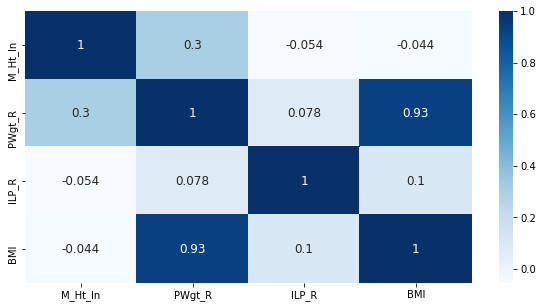

In [ ]:
heat_map(newdf[num_cols])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


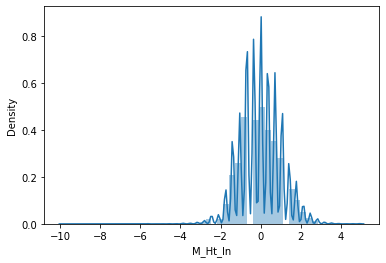

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


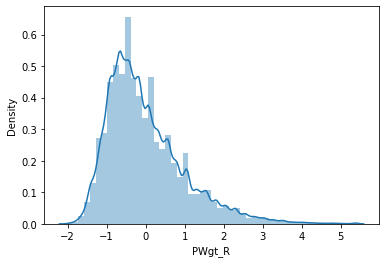

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


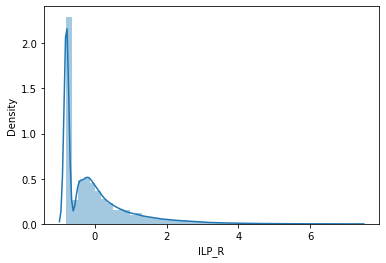

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


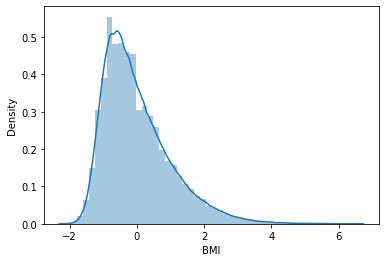

In [ ]:
for col in num_cols:
  sns.distplot(newdf[col])
  plt.show()

Since none of the numerical features followed Normal distribution, ANOVA test could not be used to analyse the effect of these features on Birth Weight. Hence, Kriskal-Wallis H Test was used.


 M_HT_IN


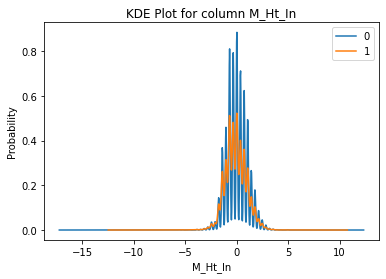

H Statistic: 474.6737811585029
p-value: 3.0812741873981918e-105

 PWGT_R


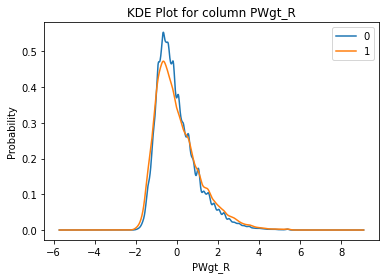

H Statistic: 29.435500943904806
p-value: 5.780891275842571e-08

 ILP_R


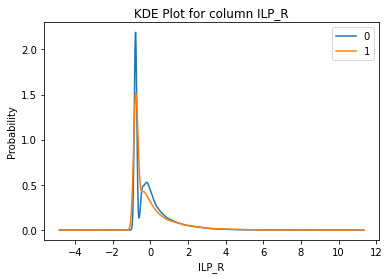

H Statistic: 538.015929047936
p-value: 5.094064219764478e-119

 BMI


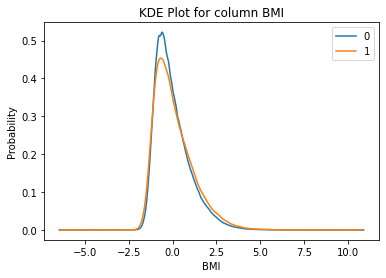

H Statistic: 208.13502986382775
p-value: 3.5055638380450067e-47


In [ ]:
for col in num_cols: 
  print("\n",col.upper())
  kde(newdf, col)
  kruskal_wallis(newdf,col)

In [ ]:
newdf[num_cols].corr()

,M_Ht_In,PWgt_R,ILP_R,BMI
M_Ht_In,1.000000,0.304765,-0.053670,-0.043586
PWgt_R,0.304765,1.000000,0.078158,0.934420
ILP_R,-0.053670,0.078158,1.000000,0.102974
BMI,-0.043586,0.934420,0.102974,1.000000


Since 'Mother's Weight (PWgt_R)' and 'Mother's Height (M_Ht_In)' were highly correlated, they were dropped and 'Mother's BMI (BMI)' was used instead.

In [ ]:
num_cols.remove('PWgt_R')
num_cols.remove('M_Ht_In')

In [ ]:
newdf.drop(['M_Ht_In', 'PWgt_R'], axis=1, inplace=True)

In [ ]:
newdf.shape

(870721, 18)

In [ ]:
num_cols = ['BMI', 'ILP_R']

## Categorical Features

In [ ]:
cat_cols = [col for col in newdf.columns if col not in num_cols+['DBWT']]

In [ ]:
for col in cat_cols:
  print("\n",col.upper())
  chisq(newdf, col)


 CIG_0
ChiSq Statistics: 1227.990928702534
p-value: 5.03671590554871e-269
Cramer's V: 0.03754

 DMAR
ChiSq Statistics: 1907.6979935435713
p-value: 0.0
Cramer's V: 0.04678

 IP_GON
ChiSq Statistics: 36.132538627326106
p-value: 1.8434289528009407e-09
Cramer's V: 0.00635

 MBSTATE_REC
ChiSq Statistics: 288.39159124008097
p-value: 1.1143390004770593e-64
Cramer's V: 0.01817

 MEDUC
ChiSq Statistics: 963.1286943990433
p-value: 1.1132089807017874e-203
Cramer's V: 0.03314

 MRACE6
ChiSq Statistics: 4812.100363966
p-value: 0.0
Cramer's V: 0.0743

 NO_INFEC
ChiSq Statistics: 130.5865974074617
p-value: 3.0493487212616664e-30
Cramer's V: 0.0122

 NO_MMORB
ChiSq Statistics: 80.32085025885105
p-value: 3.182926993354889e-19
Cramer's V: 0.00954

 NO_RISKS
ChiSq Statistics: 6015.782434804285
p-value: 0.0
Cramer's V: 0.08311

 PRECARE
ChiSq Statistics: 2538.950843775361
p-value: 0.0
Cramer's V: 0.0539

 PRIORTERM
ChiSq Statistics: 267.90497561328533
p-value: 3.24726072217254e-60
Cramer's V: 0.01751

 R

Using Chi-Square Test of Independence and Cramer's V, the association between the nominal features and Birth Weight were studied. The irrelevant features were removed.

In [ ]:
cat_cols.remove("IP_GON")
cat_cols.remove("NO_MMORB")
cat_cols.remove("MEDUC")
cat_cols.remove("NO_INFEC")

In [ ]:
newdf.drop(['IP_GON', 'NO_MMORB', 'MEDUC', 'NO_INFEC'],axis=1,inplace=True)

In [ ]:
newdf.shape

(870721, 14)

## Modelling using Imbalanced Dataset

In [ ]:
X = newdf.drop('DBWT', axis=1)
y = newdf['DBWT'].copy(deep=True)

In [ ]:
X.columns

Index(['BMI', 'CIG_0', 'DMAR', 'ILP_R', 'MBSTATE_REC', 'MRACE6', 'NO_RISKS',
       'PRECARE', 'PRIORTERM', 'RF_CESAR', 'SEX', 'Age', 'Visits'],
      dtype='object')

In [ ]:
Xdumm = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [ ]:
Xdumm.rename(columns = {'Age_(21.0, 27.0]':'Age_21_27','Age_(27.0, 33.0]':'Age_28_33','Age_(33.0, 39.0]':'Age_34_39','Age_(39.0, 45.0]':'Age_40_45', 'Visits_(5.0, 10.0]':'Visits_6_10','Visits_(10.0, 15.0]':'Visits_11_15','Visits_(15.0, 20.0]':'Visits_16_20','Visits_(20.0, 25.0]':'Visits_21_25'}, inplace=True)

In [ ]:
Xdumm.columns

Index(['BMI', 'ILP_R', 'CIG_0_1', 'DMAR_2', 'DMAR_3', 'MBSTATE_REC_2',
       'MRACE6_2', 'MRACE6_3', 'MRACE6_4', 'MRACE6_5', 'MRACE6_6',
       'NO_RISKS_1', 'PRECARE_1', 'PRECARE_2', 'PRECARE_3', 'PRECARE_4',
       'PRECARE_5', 'PRECARE_6', 'PRECARE_7', 'PRECARE_8', 'PRECARE_9',
       'PRIORTERM_1', 'RF_CESAR_Y', 'SEX_M', 'Age_21_27', 'Age_28_33',
       'Age_34_39', 'Age_40_45', 'Visits_6_10', 'Visits_11_15', 'Visits_16_20',
       'Visits_21_25'],
      dtype='object')

In [ ]:
Xdumm.shape

(870721, 32)

In [ ]:
y.value_counts()/y.shape[0]

0    0.914865
1    0.085135
Name: DBWT, dtype: float64

In [ ]:
cats = [col for col in Xdumm.columns if col not in num_cols+['DBWT']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xdumm, y, test_size=0.3, random_state=24)

In [ ]:
y_train.unique()

array([0, 1])

### Decision Tree Classifier

In [ ]:
dtc =  DecisionTreeClassifier(random_state=0, max_depth=10, class_weight='balanced')   #With weights

In [ ]:
dtc.fit(X_train, y_train)  #With weights

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
dtc_pred = dtc.predict(X_test)

In [ ]:
dtc_pred

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
dtc_prob = dtc.predict_proba(X_test)[:,1]

In [ ]:
dtc_prob

array([0.29966516, 0.77743877, 0.58889028, ..., 0.54353698, 0.74170553,
       0.54353698])

In [ ]:
confusion_matrix(y_test, dtc_pred)

array([[170046,  68993],
       [  9247,  12931]])

In [ ]:
#Weights
print("Precision Score:", round(precision_score(y_test, dtc_pred),5))
print("Recall Score:", round(recall_score(y_test, dtc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, dtc_pred),5))
print("F1 Score:", round(f1_score(y_test, dtc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, dtc_prob),5))

Precision Score: 0.15784
Recall Score: 0.58306
Accuracy Score: 0.70048
F1 Score: 0.76504
ROC:  0.69734


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced')

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Obtaining the importance of all the features in the Random Forest Classifier model
feature_imp = pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print("Important Features are :\n",feature_imp)

Important Features are :
 BMI              0.443105
ILP_R            0.236479
Visits_11_15     0.027396
SEX_M            0.027300
NO_RISKS_1       0.022813
MBSTATE_REC_2    0.020062
DMAR_3           0.017461
PRIORTERM_1      0.015209
MRACE6_2         0.014874
Age_21_27        0.014393
Age_28_33        0.013989
DMAR_2           0.012211
Visits_6_10      0.011190
Age_34_39        0.011180
MRACE6_4         0.010476
PRECARE_2        0.009702
PRECARE_3        0.009498
RF_CESAR_Y       0.009181
Visits_16_20     0.009089
CIG_0_1          0.008589
MRACE6_6         0.007809
PRECARE_4        0.007258
PRECARE_1        0.006743
Age_40_45        0.005517
PRECARE_5        0.005501
PRECARE_6        0.004221
PRECARE_7        0.004148
MRACE6_3         0.003935
PRECARE_8        0.003613
Visits_21_25     0.003180
PRECARE_9        0.002131
MRACE6_5         0.001746
dtype: float64


In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
rfc_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
rfc_prob = rfc.predict_proba(X_test)[:,1]

In [ ]:
rfc_prob

array([0.        , 0.9       , 0.49      , ..., 0.43633009, 0.02      ,
       0.06      ])

In [ ]:
confusion_matrix(y_test, rfc_pred)

array([[229270,   9769],
       [ 19617,   2561]])

In [ ]:
#With Weights
print("Precision Score:", round(precision_score(y_test, rfc_pred),5))
print("Recall Score:", round(recall_score(y_test, rfc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, rfc_pred),5))
print("F1 Score:", round(f1_score(y_test, rfc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, rfc_prob),5))

Precision Score: 0.2077
Recall Score: 0.11547
Accuracy Score: 0.8875
F1 Score: 0.87259
ROC:  0.63686


### Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#Loss Function used
gbc.loss_
#Deviance

In [ ]:
#Obtaining the importance of all the features in the Gradient Boosting Classifier model
feature_imp = pd.Series(gbc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print("Important Features are :\n",feature_imp)

Important Features are :
 ILP_R            0.503409
Visits_11_15     0.132908
NO_RISKS_1       0.085520
Visits_6_10      0.066851
MRACE6_2         0.058647
RF_CESAR_Y       0.037174
Visits_16_20     0.026961
BMI              0.015256
CIG_0_1          0.013367
PRECARE_1        0.011458
PRECARE_8        0.009578
PRECARE_9        0.007073
Visits_21_25     0.006628
PRECARE_7        0.004700
DMAR_2           0.003917
PRECARE_2        0.003093
Age_40_45        0.002352
MBSTATE_REC_2    0.002020
SEX_M            0.002012
PRIORTERM_1      0.001953
Age_34_39        0.001651
PRECARE_6        0.001649
DMAR_3           0.000831
PRECARE_5        0.000555
MRACE6_5         0.000138
MRACE6_4         0.000108
Age_21_27        0.000086
MRACE6_3         0.000068
Age_28_33        0.000037
MRACE6_6         0.000000
PRECARE_3        0.000000
PRECARE_4        0.000000
dtype: float64


In [ ]:
gbc_pred = gbc.predict(X_test)

In [ ]:
gbc_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
gbc_prob = gbc.predict_proba(X_test)[:,1]

In [ ]:
gbc_prob

array([0.04403201, 0.22704698, 0.07645521, ..., 0.09420722, 0.2004879 ,
       0.09961025])

In [ ]:
confusion_matrix(y_test, gbc_pred)

array([[238494,    545],
       [ 21180,    998]])

In [ ]:
print("Precision Score:", round(precision_score(y_test, gbc_pred),5))
print("Recall Score:", round(recall_score(y_test, gbc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, gbc_pred),5))
print("F1 Score:", round(f1_score(y_test, gbc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, gbc_prob),5))

Precision Score: 0.64679
Recall Score: 0.045
Accuracy Score: 0.91683
F1 Score: 0.88238
ROC:  0.71179


### XGBoost

In [ ]:
xbgc = xgb.XGBClassifier()

In [ ]:
xbgc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xbgc_pred = xbgc.predict(X_test)

In [ ]:
xbgc_prob = xbgc.predict_proba(X_test)[:,1]

In [ ]:
confusion_matrix(y_test, xbgc_pred)

array([[238644,    395],
       [ 21333,    845]])

In [ ]:
print("Precision Score:", round(precision_score(y_test, xbgc_pred),5))
print("Recall Score:", round(recall_score(y_test, xbgc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, xbgc_pred),5))
print("F1 Score:", round(f1_score(y_test, xbgc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, xbgc_prob),5))

Precision Score: 0.68145
Recall Score: 0.0381
Accuracy Score: 0.91682
F1 Score: 0.88138
ROC:  0.71097


### CatBoost

In [ ]:
CBC = CatBoostClassifier()

In [ ]:
CBC.fit(X_train,y_train, cat_features=cats)

Learning rate set to 0.159265
0:	learn: 0.5477672	total: 288ms	remaining: 4m 47s
1:	learn: 0.4526626	total: 518ms	remaining: 4m 18s
2:	learn: 0.3951976	total: 743ms	remaining: 4m 6s
3:	learn: 0.3546373	total: 998ms	remaining: 4m 8s
4:	learn: 0.3274896	total: 1.21s	remaining: 4m 1s
5:	learn: 0.3098252	total: 1.43s	remaining: 3m 56s
6:	learn: 0.2964486	total: 1.64s	remaining: 3m 52s
7:	learn: 0.2876220	total: 1.87s	remaining: 3m 51s
8:	learn: 0.2829497	total: 2.08s	remaining: 3m 49s
9:	learn: 0.2787833	total: 2.27s	remaining: 3m 45s
10:	learn: 0.2753284	total: 2.48s	remaining: 3m 43s
11:	learn: 0.2734378	total: 2.71s	remaining: 3m 43s
12:	learn: 0.2716429	total: 2.9s	remaining: 3m 40s
13:	learn: 0.2701951	total: 3.15s	remaining: 3m 42s
14:	learn: 0.2692038	total: 3.38s	remaining: 3m 42s
15:	learn: 0.2684083	total: 3.61s	remaining: 3m 42s
16:	learn: 0.2677052	total: 3.81s	remaining: 3m 40s
17:	learn: 0.2670551	total: 4.02s	remaining: 3m 39s
18:	learn: 0.2666482	total: 4.24s	remaining: 3m 

In [ ]:
cbc_pred = CBC.predict(X_test)

In [ ]:
cbc_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.unique(cbc_pred)

array([0, 1])

In [ ]:
cbc_prob = CBC.predict_proba(X_test)[:,1]     #Taking probabilities for positive outcome

In [ ]:
cbc_prob

array([0.04105999, 0.32601946, 0.06941252, ..., 0.09558203, 0.24209735,
       0.12585408])

In [ ]:
confusion_matrix(y_test, cbc_pred)

array([[237973,   1066],
       [ 20433,   1745]])

In [ ]:
print("Precision Score:", round(precision_score(y_test, cbc_pred),5))
print("Recall Score:", round(recall_score(y_test, cbc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, cbc_pred),5))
print("F1 Score:", round(f1_score(y_test, cbc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, cbc_prob),5))

Precision Score: 0.62078
Recall Score: 0.07868
Accuracy Score: 0.9177
F1 Score: 0.88741
ROC:  0.71322


## Modelling using Balanced dataset (obtained using SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTENC
# from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X.columns

Index(['BMI', 'CIG_0', 'DMAR', 'ILP_R', 'MBSTATE_REC', 'MRACE6', 'NO_RISKS',
       'PRECARE', 'PRIORTERM', 'RF_CESAR', 'SEX', 'Age', 'Visits'],
      dtype='object')

In [ ]:
smote = SMOTENC(categorical_features=[1,2,4,5,6,7,8,9,10,11,12], sampling_strategy='minority', k_neighbors=5)

In [ ]:
X_smote, y_smote = smote.fit_resample(X,y)

In [ ]:
from collections import Counter
Counter(y_smote)

Counter({0: 796592, 1: 796592})

In [ ]:
X1 = pd.DataFrame(X_smote.tolist())

In [ ]:
X1.columns = X.columns.copy()

In [ ]:
X1.head()

,BMI,CIG_0,DMAR,ILP_R,MBSTATE_REC,MRACE6,NO_RISKS,PRECARE,PRIORTERM,RF_CESAR,SEX,Age,Visits
0,0.580249,0,1,-0.358559,1,1,1,3,1,N,M,"(27.0, 33.0]","(5.0, 10.0]"
1,-0.485867,0,2,0.369112,1,3,1,5,0,N,F,"(21.0, 27.0]","(5.0, 10.0]"
2,0.671631,0,1,0.261309,1,1,1,2,0,N,F,"(21.0, 27.0]","(10.0, 15.0]"
3,-0.592479,0,1,-0.062100,1,1,1,3,0,N,F,"(27.0, 33.0]","(5.0, 10.0]"
4,0.199493,0,1,-0.789771,1,1,1,3,0,N,F,"(27.0, 33.0]","(15.0, 20.0]"


In [ ]:
smote_df = pd.concat([X1,pd.Series(y_smote.tolist(), name='DBWT')], axis=1)

In [ ]:
smote_df.to_csv('/content/drive/My Drive/Pregnancy Paper/Data/smote_df.csv',index=False)

In [ ]:
smote_df = pd.read_csv("/content/drive/My Drive/Pregnancy Paper/Data/smote_df.csv")

In [ ]:
smote_df.head()

,BMI,CIG_0,DMAR,ILP_R,MBSTATE_REC,MRACE6,NO_RISKS,PRECARE,PRIORTERM,RF_CESAR,SEX,Age,Visits,DBWT
0,0.580249,0,1,-0.358559,1,1,1,3,1,N,M,"(27.0, 33.0]","(5.0, 10.0]",0
1,-0.485867,0,2,0.369112,1,3,1,5,0,N,F,"(21.0, 27.0]","(5.0, 10.0]",0
2,0.671631,0,1,0.261309,1,1,1,2,0,N,F,"(21.0, 27.0]","(10.0, 15.0]",0
3,-0.592479,0,1,-0.062100,1,1,1,3,0,N,F,"(27.0, 33.0]","(5.0, 10.0]",0
4,0.199493,0,1,-0.789771,1,1,1,3,0,N,F,"(27.0, 33.0]","(15.0, 20.0]",0


In [ ]:
smote_df.DBWT.value_counts()

1    796592
0    796592
Name: DBWT, dtype: int64

In [ ]:
y_smote = smote_df.DBWT.copy()
X1 = smote_df.drop('DBWT',axis=1)

In [ ]:
X1.head()

,BMI,CIG_0,DMAR,ILP_R,MBSTATE_REC,MRACE6,NO_RISKS,PRECARE,PRIORTERM,RF_CESAR,SEX,Age,Visits
0,0.580249,0,1,-0.358559,1,1,1,3,1,N,M,"(27.0, 33.0]","(5.0, 10.0]"
1,-0.485867,0,2,0.369112,1,3,1,5,0,N,F,"(21.0, 27.0]","(5.0, 10.0]"
2,0.671631,0,1,0.261309,1,1,1,2,0,N,F,"(21.0, 27.0]","(10.0, 15.0]"
3,-0.592479,0,1,-0.062100,1,1,1,3,0,N,F,"(27.0, 33.0]","(5.0, 10.0]"
4,0.199493,0,1,-0.789771,1,1,1,3,0,N,F,"(27.0, 33.0]","(15.0, 20.0]"


In [ ]:
Xdumm = pd.get_dummies(X1, columns=cat_cols, drop_first=True)

In [ ]:
Xdumm.rename(columns = {'Age_(21.0, 27.0]':'Age_22_27','Age_(27.0, 33.0]':'Age_28_33','Age_(33.0, 39.0]':'Age_34_39','Age_(39.0, 45.0]':'Age_40_45', 'Visits_(5.0, 10.0]':'Visits_6_10','Visits_(10.0, 15.0]':'Visits_11_15','Visits_(15.0, 20.0]':'Visits_16_20','Visits_(20.0, 25.0]':'Visits_21_25'}, inplace=True)

In [ ]:
Xdumm.columns

Index(['BMI', 'ILP_R', 'CIG_0_1', 'DMAR_2', 'DMAR_3', 'MBSTATE_REC_2',
       'MRACE6_2', 'MRACE6_3', 'MRACE6_4', 'MRACE6_5', 'MRACE6_6',
       'NO_RISKS_1', 'PRECARE_1', 'PRECARE_2', 'PRECARE_3', 'PRECARE_4',
       'PRECARE_5', 'PRECARE_6', 'PRECARE_7', 'PRECARE_8', 'PRECARE_9',
       'PRIORTERM_1', 'RF_CESAR_Y', 'SEX_M', 'Age_22_27', 'Age_28_33',
       'Age_34_39', 'Age_40_45', 'Visits_11_15', 'Visits_16_20',
       'Visits_21_25', 'Visits_6_10'],
      dtype='object')

In [ ]:
Xdumm.shape

(1593184, 32)

In [ ]:
cats = [col for col in Xdumm.columns if col not in num_cols+['DBWT']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xdumm, y_smote, test_size=0.3, random_state=24)

### Decision Tree Classifier

In [ ]:
dtc =  DecisionTreeClassifier(random_state=0, max_depth=10)   

In [ ]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
dtc_pred = dtc.predict(X_test)

In [ ]:
dtc_pred

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
dtc_prob = dtc.predict_proba(X_test)[:,1]

In [ ]:
dtc_prob

array([0.62242856, 0.32896136, 0.48405074, ..., 0.82301448, 0.29222243,
       0.35001954])

In [ ]:
#After SMOTE
print("Classification Report:\n", classification_report(y_test,dtc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, dtc_pred))
print("Precision Score:", round(precision_score(y_test, dtc_pred),5))
print("Recall Score:", round(recall_score(y_test, dtc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, dtc_pred),5))
print("F1 Score:", round(f1_score(y_test, dtc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, dtc_prob),5))

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.71    238569
           1       0.72      0.58      0.65    239387

    accuracy                           0.68    477956
   macro avg       0.69      0.68      0.68    477956
weighted avg       0.69      0.68      0.68    477956

Confusion Matrix:
 [[184387  54182]
 [ 99522 139865]]
Precision Score: 0.72078
Recall Score: 0.58426
Accuracy Score: 0.67841
F1 Score: 0.67555
ROC:  0.74579


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Obtaining the importance of all the features in the Random Forest Classifier model
feature_imp = pd.Series(rfc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print("Important Features are :\n",feature_imp)

Important Features are :
 BMI              0.453870
ILP_R            0.282931
Visits_11_15     0.023651
NO_RISKS_1       0.022038
SEX_M            0.020715
MBSTATE_REC_2    0.014988
PRIORTERM_1      0.013827
MRACE6_2         0.013264
DMAR_3           0.012658
Visits_6_10      0.012047
Age_28_33        0.010475
Age_22_27        0.010392
DMAR_2           0.009847
Visits_16_20     0.008875
Age_34_39        0.007987
MRACE6_4         0.007732
CIG_0_1          0.007610
RF_CESAR_Y       0.007378
PRECARE_2        0.007256
PRECARE_3        0.006720
PRECARE_1        0.005466
PRECARE_4        0.004888
MRACE6_6         0.004687
Age_40_45        0.004302
PRECARE_7        0.004191
PRECARE_5        0.004137
PRECARE_8        0.003951
PRECARE_6        0.003805
Visits_21_25     0.003723
MRACE6_3         0.002861
PRECARE_9        0.002677
MRACE6_5         0.001055
dtype: float64


In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
rfc_pred

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
rfc_prob = rfc.predict_proba(X_test)[:,1]

In [ ]:
rfc_prob

array([0.2 , 0.93, 0.59, ..., 1.  , 0.26, 0.11])

In [ ]:
#With SMOTE
print("Classification Report:\n", classification_report(y_test, rfc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rfc_pred))
print("Precision Score:", round(precision_score(y_test, rfc_pred),5))
print("Recall Score:", round(recall_score(y_test, rfc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, rfc_pred),5))
print("F1 Score:", round(f1_score(y_test, rfc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, rfc_prob),5))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85    238569
           1       0.85      0.85      0.85    239387

    accuracy                           0.85    477956
   macro avg       0.85      0.85      0.85    477956
weighted avg       0.85      0.85      0.85    477956

Confusion Matrix:
 [[203698  34871]
 [ 36314 203073]]
Precision Score: 0.85345
Recall Score: 0.8483
Accuracy Score: 0.85106
F1 Score: 0.85106
ROC:  0.91401


### Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier()

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#Loss Function used
gbc.loss_
#Deviance

In [ ]:
#Obtaining the importance of all the features in the Gradient Boosting Classifier model
feature_imp = pd.Series(gbc.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print("Important Features are :\n",feature_imp)

Important Features are :
 ILP_R            0.465403
Visits_11_15     0.149153
NO_RISKS_1       0.089202
MRACE6_2         0.053418
Visits_6_10      0.041263
Visits_16_20     0.034157
BMI              0.022870
PRECARE_8        0.017497
RF_CESAR_Y       0.017226
Visits_21_25     0.013184
PRECARE_9        0.012668
PRECARE_1        0.010882
PRECARE_7        0.010145
MRACE6_3         0.009568
PRECARE_6        0.009132
DMAR_2           0.007888
MBSTATE_REC_2    0.006674
PRECARE_5        0.006249
MRACE6_6         0.005745
PRECARE_2        0.005087
PRECARE_4        0.003562
CIG_0_1          0.002613
MRACE6_5         0.002403
DMAR_3           0.001149
PRIORTERM_1      0.001086
SEX_M            0.000920
Age_34_39        0.000651
PRECARE_3        0.000107
MRACE6_4         0.000084
Age_28_33        0.000007
Age_40_45        0.000006
Age_22_27        0.000000
dtype: float64


In [ ]:
gbc_pred = gbc.predict(X_test)

In [ ]:
gbc_pred

array([1, 0, 1, ..., 1, 0, 0])

In [ ]:
gbc_prob = gbc.predict_proba(X_test)[:,1]

In [ ]:
gbc_prob

array([0.51492552, 0.39770176, 0.51780891, ..., 0.81537137, 0.29982426,
       0.30820469])

In [ ]:
print("Classification Report:\n", classification_report(y_test,gbc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,gbc_pred))
print("Precision Score:", round(precision_score(y_test, gbc_pred),5))
print("Recall Score:", round(recall_score(y_test, gbc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, gbc_pred),5))
print("F1 Score:", round(f1_score(y_test, gbc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, gbc_prob),5))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70    238569
           1       0.70      0.64      0.67    239387

    accuracy                           0.68    477956
   macro avg       0.69      0.68      0.68    477956
weighted avg       0.69      0.68      0.68    477956

Confusion Matrix:
 [[173004  65565]
 [ 85373 154014]]
Precision Score: 0.70141
Recall Score: 0.64337
Accuracy Score: 0.6842
F1 Score: 0.68368
ROC:  0.75131


### XGBoost

In [ ]:
xbgc = xgb.XGBClassifier()

In [ ]:
xbgc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xbgc_pred = xbgc.predict(X_test)

In [ ]:
xbgc_pred

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
xbgc_prob = xbgc.predict_proba(X_test)[:,1]

In [ ]:
xbgc_prob

array([0.4768398 , 0.38746753, 0.53044146, ..., 0.8207871 , 0.30277377,
       0.29858485], dtype=float32)

In [ ]:
#With SMOTE
print("Classification Report:\n", classification_report(y_test,xbgc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xbgc_pred))
print("Precision Score:", round(precision_score(y_test, xbgc_pred),5))
print("Recall Score:", round(recall_score(y_test, xbgc_pred),5))
print("Accuracy Score:", round(accuracy_score(y_test, xbgc_pred),5))
print("F1 Score:", round(f1_score(y_test, xbgc_pred, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y_test, xbgc_prob),5))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70    238569
           1       0.71      0.64      0.67    239387

    accuracy                           0.69    477956
   macro avg       0.69      0.69      0.69    477956
weighted avg       0.69      0.69      0.69    477956

Confusion Matrix:
 [[175146  63423]
 [ 86108 153279]]
Precision Score: 0.70733
Recall Score: 0.6403
Accuracy Score: 0.68714
F1 Score: 0.68646
ROC:  0.75475


### CatBoost

In [ ]:
CBC = CatBoostClassifier()

In [ ]:
X1.head()

,BMI,CIG_0,DMAR,ILP_R,MBSTATE_REC,MRACE6,NO_RISKS,PRECARE,PRIORTERM,RF_CESAR,SEX,Age,Visits
0,0.580249,0,1,-0.358559,1,1,1,3,1,N,M,"(27.0, 33.0]","(5.0, 10.0]"
1,-0.485867,0,2,0.369112,1,3,1,5,0,N,F,"(21.0, 27.0]","(5.0, 10.0]"
2,0.671631,0,1,0.261309,1,1,1,2,0,N,F,"(21.0, 27.0]","(10.0, 15.0]"
3,-0.592479,0,1,-0.062100,1,1,1,3,0,N,F,"(27.0, 33.0]","(5.0, 10.0]"
4,0.199493,0,1,-0.789771,1,1,1,3,0,N,F,"(27.0, 33.0]","(15.0, 20.0]"


In [ ]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X1, y_smote, test_size=0.3, random_state=24)

In [ ]:
CBC.fit(X0_train, y0_train, cat_features=cat_cols)

Learning rate set to 0.206138
0:	learn: 0.6607643	total: 1.75s	remaining: 29m 11s
1:	learn: 0.6414184	total: 3.74s	remaining: 31m 7s
2:	learn: 0.6316928	total: 5.01s	remaining: 27m 45s
3:	learn: 0.6245504	total: 6.64s	remaining: 27m 34s
4:	learn: 0.6168645	total: 8.19s	remaining: 27m 8s
5:	learn: 0.6123305	total: 9.17s	remaining: 25m 18s
6:	learn: 0.6090897	total: 10.4s	remaining: 24m 40s
7:	learn: 0.6066687	total: 11.5s	remaining: 23m 51s
8:	learn: 0.5968555	total: 13.3s	remaining: 24m 30s
9:	learn: 0.5883396	total: 15.2s	remaining: 25m 8s
10:	learn: 0.5817158	total: 17.1s	remaining: 25m 35s
11:	learn: 0.5763096	total: 18.7s	remaining: 25m 38s
12:	learn: 0.5742524	total: 20.1s	remaining: 25m 23s
13:	learn: 0.5716965	total: 21.8s	remaining: 25m 33s
14:	learn: 0.5701859	total: 23.1s	remaining: 25m 18s
15:	learn: 0.5689485	total: 24.5s	remaining: 25m 4s
16:	learn: 0.5649992	total: 26s	remaining: 25m 6s
17:	learn: 0.5610632	total: 28s	remaining: 25m 27s
18:	learn: 0.5583268	total: 29.4s	r

In [ ]:
cbc_pred0 = CBC.predict(X0_test)

In [ ]:
cbc_pred0

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
cbc_prob0 = CBC.predict_proba(X0_test)[:,1]     #Taking probabilities for positive outcome

In [ ]:
cbc_prob0

array([0.06770003, 0.3363939 , 0.99957902, ..., 0.64690981, 0.03229488,
       0.0534723 ])

In [ ]:
print("Classification Report:", classification_report(y0_test, cbc_pred0))
print("Confusion Matrix:\n", confusion_matrix(y0_test, cbc_pred0))
print("Precision Score:", round(precision_score(y0_test, cbc_pred0),5))
print("Recall Score:", round(recall_score(y0_test, cbc_pred0),5))
print("Accuracy Score:", round(accuracy_score(y0_test, cbc_pred0),5))
print("F1 Score:", round(f1_score(y0_test, cbc_pred0, average='weighted'),5))
print("ROC: ", round(roc_auc_score(y0_test, cbc_prob0),5))

Classification Report:               precision    recall  f1-score   support

           0       0.83      0.92      0.87    238569
           1       0.91      0.81      0.85    239387

    accuracy                           0.86    477956
   macro avg       0.87      0.86      0.86    477956
weighted avg       0.87      0.86      0.86    477956

Confusion Matrix:
 [[218742  19827]
 [ 46248 193139]]
Precision Score: 0.9069
Recall Score: 0.80681
Accuracy Score: 0.86176
F1 Score: 0.86134
ROC:  0.93421
